In [277]:
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, roc_curve
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

from imblearn.over_sampling import SMOTE




In [152]:
def scaler(X_train, X_test, minmax = False):
    if minmax == True:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# def get_indices(df):
#     X_full_indices = df.drop(['pt_suc', 'pt_attempt'], axis =1 ).columns
#     return X_full_indices


def splitter(df, target = 'pt_attempt', test_size = .25, random_state = 29, VIF_drop = False, scaled = False, minmax = False):
    _targets = ['pt_attempt', 'pt_suc']
    if VIF_drop == True:
        df = df.drop(vifdrops, axis = 1)
        y = df[target]
        X = df.drop(_targets, axis = 1)
    if VIF_drop == False:
        y = df[target]
        X = df.drop(_targets, axis = 1)
    colnames = X.columns
    idx = colnames.to_numpy()
    indices = np.concatenate((['constant'], idx) )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state= random_state, stratify = y )
    if scaled == True:
        X_train, X_test = scaler(X_train, X_test, minmax = minmax)
    X_train = add_constant(X_train)    
    X_test =  add_constant(X_test)    
    return X_train, X_test, y_train, y_test, indices

def upsampler(X_train, y_train, target = 'pt_attempt'):
    X = pd.concat([X_train, y_train], axis=1) 
    no_coup = X[X[target]==0]
    coup = X[X[target]==1]
    coups_upsampled = resample(coup,
                          replace=True, # sample with replacement
                          n_samples=len(no_coup), # match number in majority class
                          random_state=29)
    upsampled = pd.concat([no_coup, coups_upsampled])
    y_up = upsampled[target]
    X_up = upsampled.drop(target, axis = 1)
    return X_up, y_up

def downsampler(X_train, y_train, target = 'pt_attempt'):
    X = pd.concat([X_train, y_train], axis=1) 
    no_coup = X[X[target]==0]
    coup = X[X[target]==1]
    coups_downsampled = resample(no_coup,
                          replace=True, # sample with replacement
                          n_samples=len(coup), # match number in majority class
                          random_state=29)
    downsampled = pd.concat([coup, coups_downsampled])
    y_down = downsampled[target]
    X_down = downsampled.drop(target, axis = 1)
    return X_down, y_down

def smoter(X_train, y_train, ratio = 1.0):
    sm = SMOTE(random_state=29, ratio=ratio)
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)
    return X_train_sm, y_train_sm


def variance_inflation_factors(X):
    # X = add_constant(X)
    vifs = pd.Series(
        [1 / (1. - OLS(X[col].values, 
                       X.loc[:, X.columns != col].values).fit().rsquared) 
         for col in X],
        index=X.columns,
        name='VIF'
    )
    return vifs.sort_values()

#these were determined through looking at VIF outputs and removing one member of pairs that seemed correlated
VIFdrops = ['election_recent', 'imports', 'exports', 'victory_recent', 'upop', 'direct_recent', 'leg_recent', 'pec', 'anticipation', 'cinc', 'lead_recent']



def data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 29, VIF_drop = False, scaled = False, minmax = False, resampler = None, sample_ratio = 1):
    X_train, X_test, y_train, y_test, indices = splitter(df, target = 'pt_attempt', test_size = .25, 
                                                random_state = 29, VIF_drop = VIF_drop, scaled = scaled, minmax = minmax)
    if resampler == 'upsample':
        X_train, y_train = upsampler(X_train, y_train)
    if resampler == 'downsample':
        X_train, y_train = downsampler(X_train, y_train)
    if resampler == 'smote':
        X_train, y_train = smoter(X_train, y_train, ratio = sample_ratio)
    return X_train, X_test, y_train, y_test, indices

def get_feature_weights(model, indices):
    d_log_vals = {}
    for idx, feat in enumerate(model.coef_[0]):
        d_log_vals[indices[idx]] = feat  
    s_log_vals = (pd.Series(d_log_vals)).sort_values()
    return s_log_vals

def metric_test(model, X_test, y_test):
    preds = model.predict(X_test)
    print('accuracy = ' + str(accuracy_score(y_test, preds)))
    print('recall = ' + str(recall_score(y_test, preds)))
    print('precision = ' + str(precision_score(y_test, preds)))
    print('f1 score = ' + str(f1_score(y_test, preds)))
    print('accuracy + recall = ' + str(accuracy_score(y_test, preds) + recall_score(y_test, preds)))
    print('r2_score = ' + str(r2_score(y_test, preds)))

    
    

def fit_test_model(model, X_train, X_test, y_train, y_test, indices, do_metric_test = True, get_features = False):
    model.fit(X_train, y_train)
    if do_metric_test == True:
        metric_test(model, X_test, y_test)
    if get_features == True:
        features = get_feature_weights(model, indices)
        print(features)
    return model

In [153]:
df = pd.read_pickle('../data/pickles/df_one_hot_num.pkl')

In [126]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 29, VIF_drop = True, scaled = True, minmax = True, resampler = 'smote', sample_ratio = 1)


In [127]:
indices

array(['constant', 'year', 'month', 'elected', 'age', 'male',
       'militarycareer', 'tenure_months', 'ref_ant', 'leg_ant',
       'exec_ant', 'irreg_lead_ant', 'election_now', 'exec_recent',
       'ref_recent', 'indirect_recent', 'defeat_recent', 'change_recent',
       'nochange_recent', 'delayed', 'lastelection', 'loss', 'irregular',
       'prev_conflict', 'precip', 'milex', 'milper', 'irst', 'population',
       'Dominant Party', 'Foreign/Occupied', 'Indirect Military',
       'Military', 'Military-Personal', 'Monarchy', 'Oligarchy',
       'Party-Military', 'Party-Personal',
       'Party-Personal-Military Hybrid', 'Personal Dictatorship',
       'Presidential Democracy', 'Provisional - Civilian',
       'Provisional - Military', 'Warlordism', 'trade balance',
       'urban_percent', 'mil_percent'], dtype=object)

In [95]:
sum(y_train)

79174.0

In [128]:
ridge_scaled = LogisticRegressionCV(
        cv=5, dual=False,
        penalty='elasticnet', 
        scoring='recall',
        solver='saga', 
        n_jobs = 2,
        tol=0.0001,
        max_iter=100,
        l1_ratios = [0, .5, 1])

In [149]:
vifdrops = ['mil_percent', 'election_recent', 'imports', 'exports', 'upop', 'direct_recent', 'leg_recent', 'pec', 'anticipation', 'cinc', 'lead_recent']

In [150]:
df.columns

Index(['year', 'month', 'elected', 'age', 'male', 'militarycareer',
       'tenure_months', 'anticipation', 'ref_ant', 'leg_ant', 'exec_ant',
       'irreg_lead_ant', 'election_now', 'election_recent', 'leg_recent',
       'exec_recent', 'lead_recent', 'ref_recent', 'direct_recent',
       'indirect_recent', 'victory_recent', 'defeat_recent', 'change_recent',
       'nochange_recent', 'delayed', 'lastelection', 'loss', 'irregular',
       'prev_conflict', 'pt_suc', 'pt_attempt', 'precip', 'imports', 'exports',
       'milex', 'milper', 'irst', 'pec', 'upop', 'cinc', 'population',
       'Dominant Party', 'Foreign/Occupied', 'Indirect Military', 'Military',
       'Military-Personal', 'Monarchy', 'Oligarchy', 'Party-Military',
       'Party-Personal', 'Party-Personal-Military Hybrid',
       'Personal Dictatorship', 'Presidential Democracy',
       'Provisional - Civilian', 'Provisional - Military', 'Warlordism',
       'trade balance', 'urban_percent', 'mil_percent'],
      dtype='obje

In [229]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import plot_partial_dependence

In [239]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 30, VIF_drop = True, scaled = False, minmax = False, resampler = 'upsample', sample_ratio = 1)

# clf = GradientBoostingClassifier(random_state=29, subsample = .3, n_estimators = 3 )
clf = RandomForestClassifier( n_estimators = 1000, max_depth = 3)
clf.fit(X_train, y_train)

/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [240]:
metric_test(clf, X_train, y_train)

accuracy = 0.7621504534316821
recall = 0.8320660822997449
precision = 0.7299905811956341
f1 score = 0.7776931749095437
accuracy + recall = 1.594216535731427
r2_score = 0.04860181372672845


In [241]:
metric_test(clf, X_test, y_test)

accuracy = 0.6899101954569467
recall = 0.7927927927927928
precision = 0.010624169986719787
f1 score = 0.020967357636406954
accuracy + recall = 1.4827029882497396
r2_score = -73.3474300718816


In [242]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 30, VIF_drop = True, scaled = False, minmax = False, resampler = 'downsample', sample_ratio = 1)

# clf = GradientBoostingClassifier(random_state=29, subsample = .3, n_estimators = 3 )
clf = RandomForestClassifier( n_estimators = 1000, max_depth = 3)
clf.fit(X_train, y_train)

/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [243]:
metric_test(clf, X_train, y_train)

accuracy = 0.7650602409638554
recall = 0.858433734939759
precision = 0.7233502538071066
f1 score = 0.7851239669421487
accuracy + recall = 1.6234939759036144
r2_score = 0.06024096385542166


In [244]:
metric_test(clf, X_test, y_test)

accuracy = 0.6296505924081202
recall = 0.8288288288288288
precision = 0.0093042071197411
f1 score = 0.018401840184018404
accuracy + recall = 1.458479421236949
r2_score = -87.79533051296154


In [248]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 30, VIF_drop = True, scaled = False, minmax = False, resampler = 'upsample', sample_ratio = 1)

# clf = GradientBoostingClassifier(random_state=29, subsample = .3, n_estimators = 3 )
clf = RandomForestClassifier( n_estimators = 1000, max_depth = 3)
clf.fit(X_train, y_train)

/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [249]:
metric_test(clf, X_train, y_train)

accuracy = 0.7636471568949402
recall = 0.8404021522216889
precision = 0.7285607918710582
f1 score = 0.7804952434575547
accuracy + recall = 1.604049309116629
r2_score = 0.05458862757976102


In [250]:
metric_test(clf, X_test, y_test)

accuracy = 0.6847030412799034
recall = 0.7927927927927928
precision = 0.010450065312908206
f1 score = 0.02062822315986873
accuracy + recall = 1.4774958340726962
r2_score = -74.59590237048462


In [263]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 30, VIF_drop = True, scaled = False, minmax = False, resampler = 'upsample', sample_ratio = 1)

# clf = GradientBoostingClassifier(random_state=29, subsample = .3, n_estimators = 3 )
clf = RandomForestClassifier( n_estimators = 1000, max_depth = 3, n_jobs = -1)
clf.fit(X_train, y_train)

/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [264]:
metric_test(clf, X_train, y_train)

accuracy = 0.7649101977922045
recall = 0.8434334503751232
precision = 0.728953803161296
f1 score = 0.7820262088510499
accuracy + recall = 1.6083436481673277
r2_score = 0.05964079116881804


In [265]:
metric_test(clf, X_test, y_test)

accuracy = 0.6828541242170402
recall = 0.7747747747747747
precision = 0.010158280179541696
f1 score = 0.02005363180599277
accuracy + recall = 1.457628898991815
r2_score = -75.03920050549584


/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/sklearn/inspection/partial_dependence.py:658: UserWarning: Attempting to set identical bottom == top == 0.4209516592488547 results in singular transformations; automatically expanding.
  ax.set_ylim(pdp_lim[1])
/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/sklearn/inspection/partial_dependence.py:600: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/sklearn/inspection/partial_dependence.py:600: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning,

/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/sklearn/inspection/partial_dependence.py:600: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/sklearn/inspection/partial_dependence.py:600: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/sklearn/inspection/partial_dependence.py:600: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface

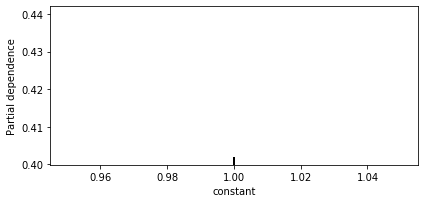

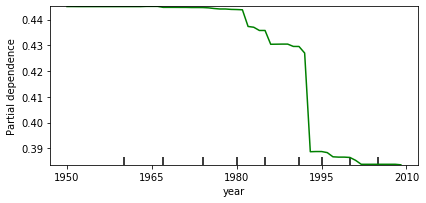

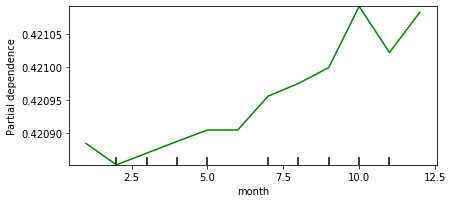

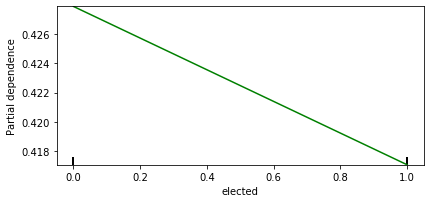

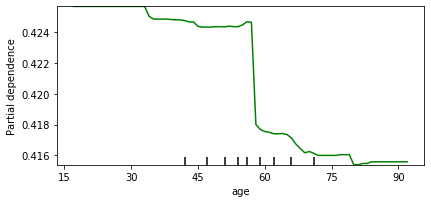

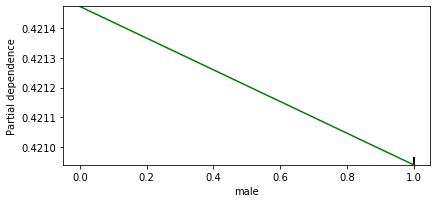

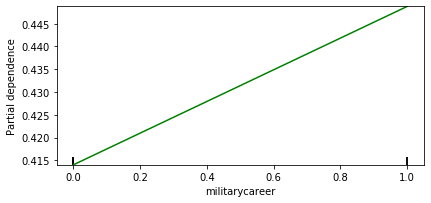

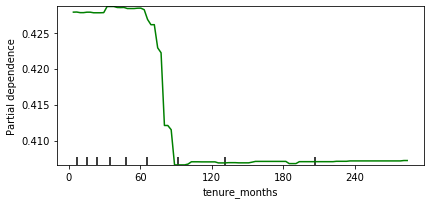

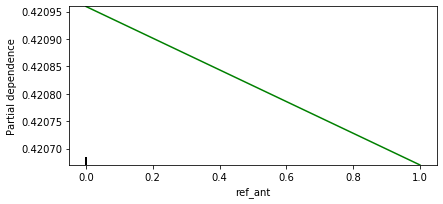

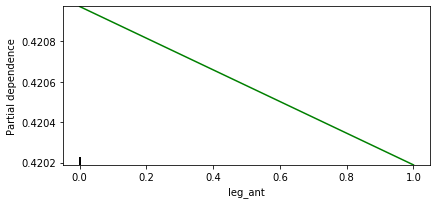

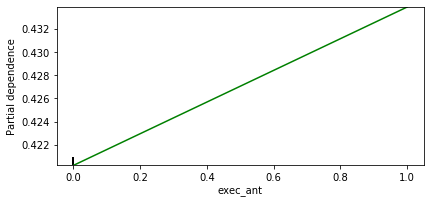

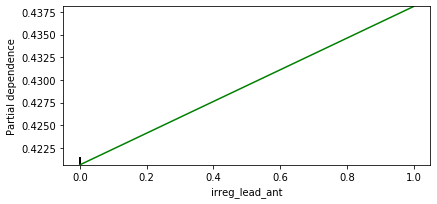

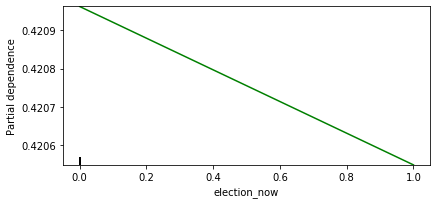

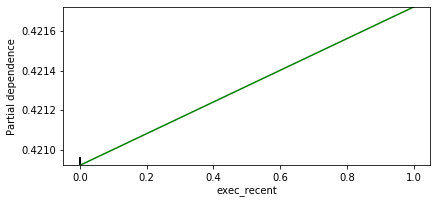

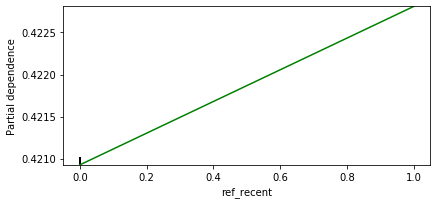

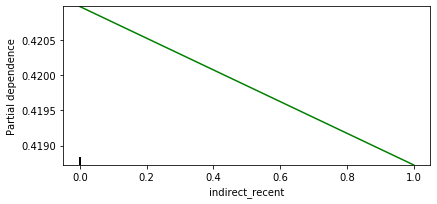

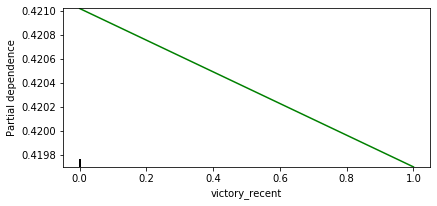

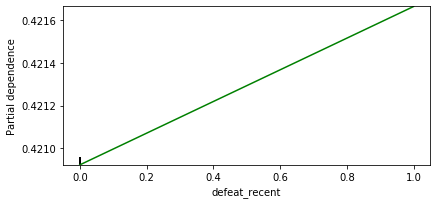

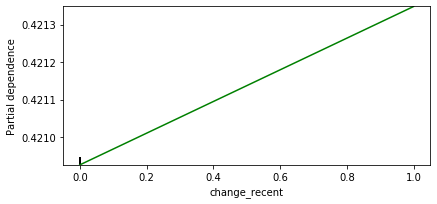

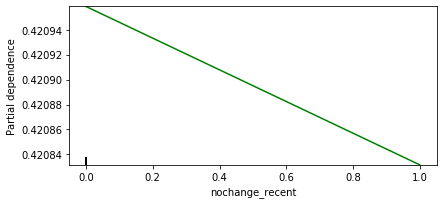

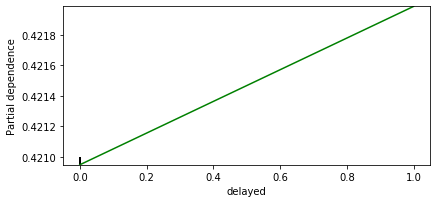

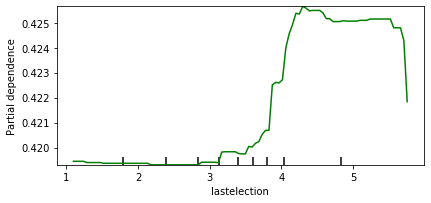

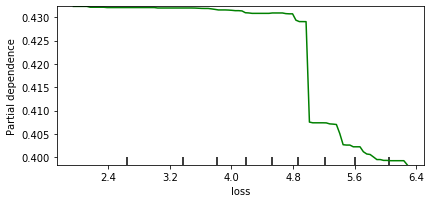

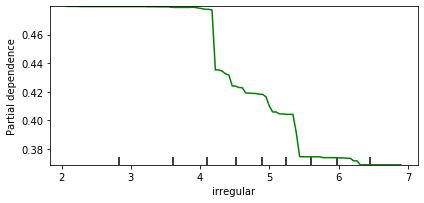

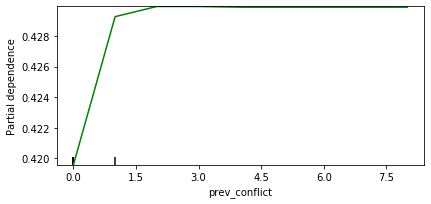

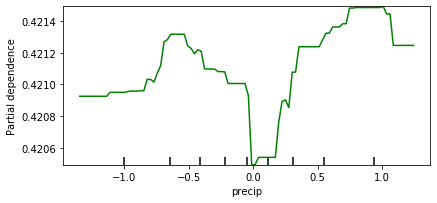

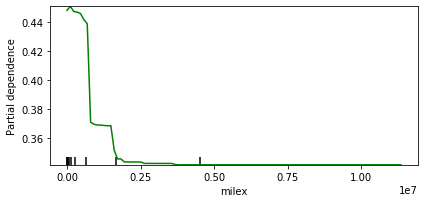

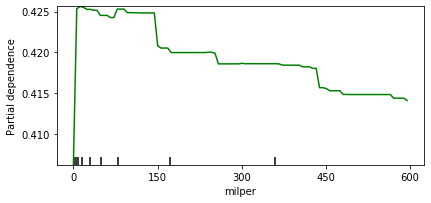

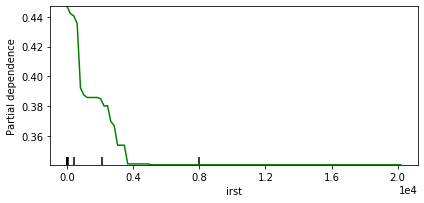

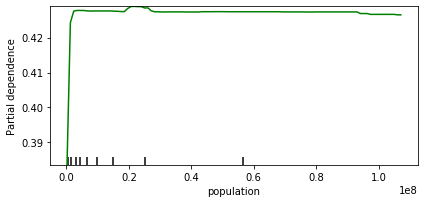

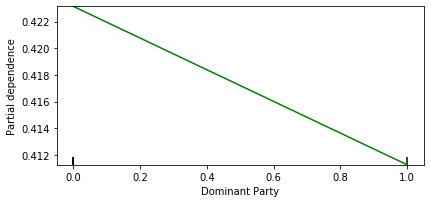

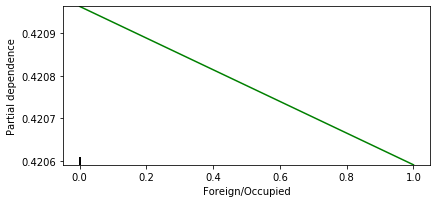

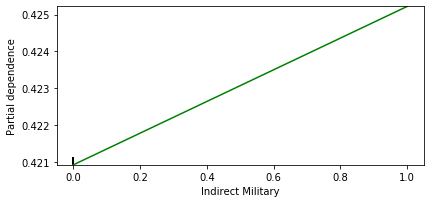

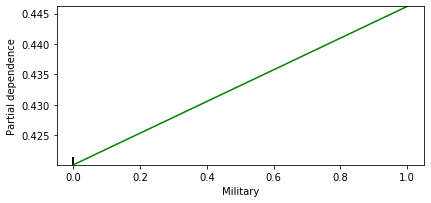

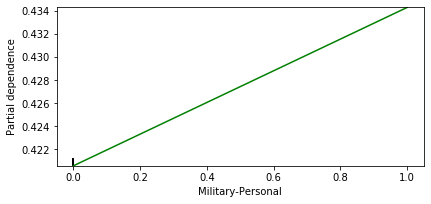

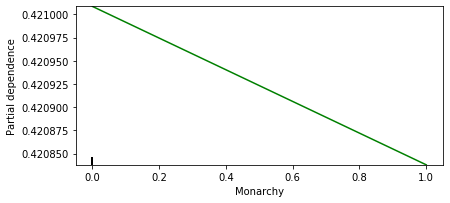

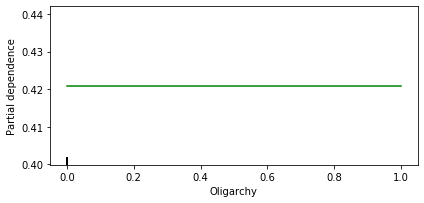

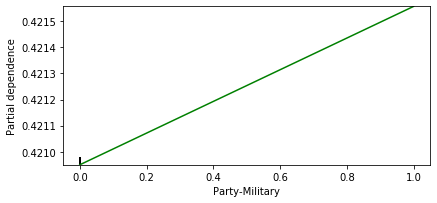

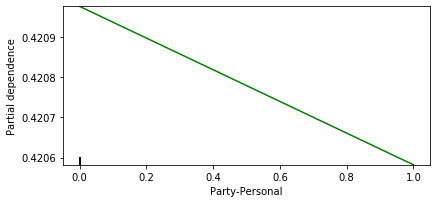

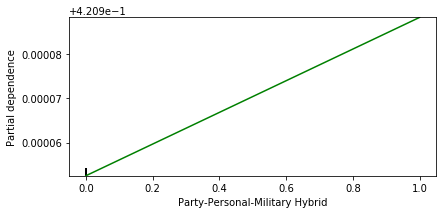

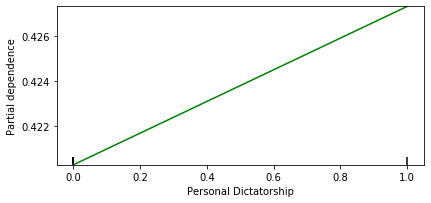

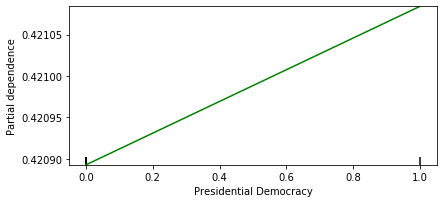

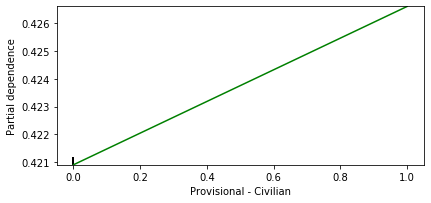

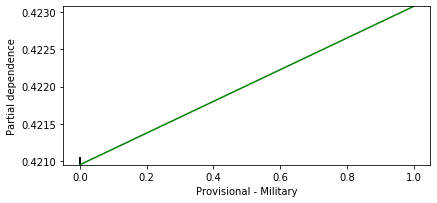

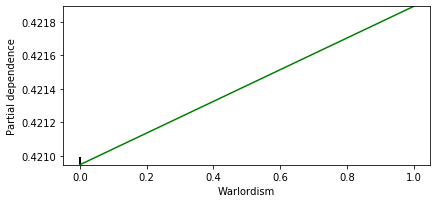

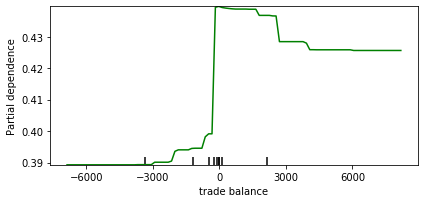

In [276]:
for i in range(46):
    plot_partial_dependence(clf, X_test, [i], indices) 

In [271]:
for idx, val in enumerate(indices):
    print('====')
    print(idx)
    print(val)
    print('====')
    

====
0
constant
====
====
1
year
====
====
2
month
====
====
3
elected
====
====
4
age
====
====
5
male
====
====
6
militarycareer
====
====
7
tenure_months
====
====
8
ref_ant
====
====
9
leg_ant
====
====
10
exec_ant
====
====
11
irreg_lead_ant
====
====
12
election_now
====
====
13
exec_recent
====
====
14
ref_recent
====
====
15
indirect_recent
====
====
16
victory_recent
====
====
17
defeat_recent
====
====
18
change_recent
====
====
19
nochange_recent
====
====
20
delayed
====
====
21
lastelection
====
====
22
loss
====
====
23
irregular
====
====
24
prev_conflict
====
====
25
precip
====
====
26
milex
====
====
27
milper
====
====
28
irst
====
====
29
population
====
====
30
Dominant Party
====
====
31
Foreign/Occupied
====
====
32
Indirect Military
====
====
33
Military
====
====
34
Military-Personal
====
====
35
Monarchy
====
====
36
Oligarchy
====
====
37
Party-Military
====
====
38
Party-Personal
====
====
39
Party-Personal-Military Hybrid
====
====
40
Personal Dictatorship


In [166]:
prob_preds = clf.predict_proba(X_test)

In [167]:
preds = clf.predict(X_test)

In [208]:
metric_test(clf, X_train, y_train)

accuracy = 0.9741013464015965
recall = 0.9589890620658297
precision = 0.9888774566624555
f1 score = 0.9737039530633838
accuracy + recall = 1.933090408467426
r2_score = 0.8964053856063859


In [209]:
metric_test(clf, X_test, y_test)

accuracy = 0.9848690664855483
recall = 0.08108108108108109
precision = 0.02922077922077922
f1 score = 0.04295942720763723
accuracy + recall = 1.0659501475666293
r2_score = -2.6278071865203847


In [173]:
indices

array(['constant', 'year', 'month', 'elected', 'age', 'male',
       'militarycareer', 'tenure_months', 'ref_ant', 'leg_ant',
       'exec_ant', 'irreg_lead_ant', 'election_now', 'exec_recent',
       'ref_recent', 'indirect_recent', 'victory_recent', 'defeat_recent',
       'change_recent', 'nochange_recent', 'delayed', 'lastelection',
       'loss', 'irregular', 'prev_conflict', 'precip', 'milex', 'milper',
       'irst', 'population', 'Dominant Party', 'Foreign/Occupied',
       'Indirect Military', 'Military', 'Military-Personal', 'Monarchy',
       'Oligarchy', 'Party-Military', 'Party-Personal',
       'Party-Personal-Military Hybrid', 'Personal Dictatorship',
       'Presidential Democracy', 'Provisional - Civilian',
       'Provisional - Military', 'Warlordism', 'trade balance',
       'urban_percent'], dtype=object)

In [284]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 30, VIF_drop = True, scaled = False, minmax = False, resampler = None, sample_ratio = 1)
#clf = GradientBoostingClassifier(random_state=29, subsample = .3, n_estimators = 3, )
clf = RandomForestClassifier( n_estimators = 500, max_depth = 5, n_jobs = -1, class_weight = "balanced")
#clf = AdaBoostClassifier(learning_rate = .2)
clf.fit(X_train, y_train)
metric_test(clf, X_train, y_train)
metric_test(clf, X_test, y_test)

/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


accuracy = 0.7606721505295198
recall = 0.8343373493975904
precision = 0.01438961038961039
f1 score = 0.02829128791747523
accuracy + recall = 1.59500949992711
r2_score = -56.55358443397965
accuracy = 0.7543204286468945
recall = 0.6846846846846847
precision = 0.0115995115995116
f1 score = 0.02281254690079544
accuracy + recall = 1.439005113331579
r2_score = -57.90437055220505


In [293]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 30, VIF_drop = True, scaled = False, minmax = False, resampler = 'smote', sample_ratio = 1)
clf = RandomForestClassifier( n_estimators = 1000, max_depth = 5, n_jobs = -1,)
clf.fit(X_train, y_train)
print('====train====')
metric_test(clf, X_train, y_train)
print('====test====')
metric_test(clf, X_test, y_test)

/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


====train====
accuracy = 0.897270568621012
recall = 0.9074948846843661
precision = 0.8893097174260146
f1 score = 0.898310276494527
accuracy + recall = 1.804765453305378
r2_score = 0.5890822744840478
====test====
accuracy = 0.8846124820768244
recall = 0.3783783783783784
precision = 0.013856812933025405
f1 score = 0.02673456397199236
accuracy + recall = 1.262990860455203
r2_score = -26.665422384985877


In [300]:
X_train, X_test, y_train, y_test, indices = data_pipeline(df, target = 'pt_attempt', test_size = .25, random_state = 30, VIF_drop = True, scaled = False, minmax = False, resampler = 'smote', sample_ratio = 1)
lg = LogisticRegressionCV(cv=5, dual=False,
        penalty='elasticnet', 
        scoring='roc_auc',
        solver='saga', 
        n_jobs = 2,
        tol=0.0001,
        max_iter=100,
        l1_ratios = [0, .5, 1])
lg.fit(X_train, y_train)

/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/taylorbritt/opt/anaconda3/lib/python3.7/site-packages/sklearn/

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=[0, 0.5, 1], max_iter=100, multi_class='warn',
                     n_jobs=2, penalty='elasticnet', random_state=None,
                     refit=True, scoring='roc_auc', solver='saga', tol=0.0001,
                     verbose=0)

In [301]:
print('====train====')
metric_test(lg, X_train, y_train)
print('====test====')
metric_test(lg, X_test, y_test)

====train====
accuracy = 0.49443630484755097
recall = 0.0
precision = 0.0
f1 score = 0.0
accuracy + recall = 0.49443630484755097
r2_score = -1.0222547806097961
====test====
accuracy = 0.9847181344804166
recall = 0.0
precision = 0.0
f1 score = 0.0
accuracy + recall = 0.9847181344804166
r2_score = -2.6639947893784433


In [299]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']